# Machine-learning Notebook - experimentation for calculating pick depth prediction from pick label classification prediction
- Machine_Learning_vG-VD_2018-12-28
- This version is an attempt to clean things up compared to version VG-VC

Specifically, I'd like to clean things up such that:
- All imports are on top
- Notebook is broken down into sections
- All input variables are inside of a single object defined at the top
- functions are better defined and documented
- Everything is done inside functions except for some display
- Inputs can be defined at start and then all functions below ran without further input.

## Import modules

In [213]:
import pandas as pd
import numpy as np
import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
import dask
import dask.dataframe as dd
from dask.distributed import Client
import random
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import multiprocessing
#### Adding this bit to silence an error that was causing the notebook to have a dead kernal
#### This is an unsafe solution but couldn't get any  of the "right solutions" to work!
#### Ended up using this = https://www.kaggle.com/c/bosch-production-line-performance/discussion/25082
#### Other solutions = https://github.com/dmlc/xgboost/issues/1715 but the solution here didn't seem to work for me?
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## pandas Options to be run so everything displays properly

In [214]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

In [215]:
#### Optional checks
print(welly.__version__)
print(dask.__version__)
print(pd.__version__)

0.3.5
0.18.2
0.23.3


In [216]:
## content_class():

## Input variables defined at start

In [217]:
class ML_obj_class():
    """doc string"""
    def __init__(self, knn_dir,load_dir,features_dir,machine_learning_dir,h5_to_load ):
        self.knn_dir = knn_dir
        self.load_dir = load_dir
        self.features_dir = features_dir
        self.machine_learning_dir = machine_learning_dir
        self.h5_to_load = h5_to_load 
        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.test_y = None
        self.train_index = None
        self.test_index = None
        self.preSplitpreBal = None
        
    def check_test_df_same_size(self):
        """doc string goes here"""
        if len(self.test_X) == len(self.test_y) and len(self.test_y)==len(self.test_index):
            response = "PASSED: test_X and test_y and test_index are all the same size as asserted "+str(len(self.test_X))
        else:
            response = "FAIL?: test_X and test_y in the test dataset should be the same size BUT THEY ARE NOT!!! test_X = "+str(len(self.test_X))+" and test_y ="+str(len(self.test_y))+" and test_index="+str(len(self.test_index))
        return response
    
    def check_train_df_same_size(self):
        """doc string goes here"""
        if len(self.train_X) == len(self.train_y) and len(self.train_y)==len(self.train_index):
            response = "PASSED: train_X and train_y and train_index are all the same size as asserted "+str(len(self.train_X))
        else:
            response = "FAIL?: train_X and train_y and train_index should be the same size BUT THEY ARE NOT!!! train_X = "+str(len(self.train_X))+" and train_y ="+str(len(self.train_y))+" and train_index="+str(len(self.train_index))
        return response
        
    def load_data_for_ml(self):
        """
        doc string goes here
        """
        self.train_X = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'train_X')
        self.train_y = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'train_y')
        self.test_X = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'test_X')
        self.test_y = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'test_y')
        self.train_index = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'train_index')
        self.test_index = pd.read_hdf(self.machine_learning_dir+self.h5_to_load, 'test_index')
        self.preSplitpreBal = pd.read_hdf(machine_learning_dir+h5_to_load, 'preSplitpreBal')
        #print("X and Y in the test dataset should be the same size", " test_X = ",len(self.test_X)," and test_y =",len(self.test_y)," and test_index=",len(self.test_index))
        check_response_test = self.check_test_df_same_size()
        check_response_train = self.check_train_df_same_size()
        print(check_response_test)
        print(check_response_train)
        return "Loading the h5 format data into pandas finished. You may access the dataframes by appending to the ML1 object .train_X | .train_y | test_X | .test_y | .train_index | .test_index | .preSplitpreBal"
    def init_XGBoost_withSettings(self):
        """
        doc string
        uses settings from previous test on manville dataset
        Use your own once you can optmize the settings
        """
        print("model = XGBClassifier(gamma=0, reg_alpha=0.3, max_depth=6, subsample=0.8, colsample_bytree= 0.8, n_estimators= 300, learning_rate= 0.03, min_child_weight= 3,n_jobs=8)")
        model = XGBClassifier(
            gamma=0, 
            reg_alpha=0.3, 
            max_depth=6, 
            subsample=0.8, 
            colsample_bytree= 0.8, 
            n_estimators= 300, 
            learning_rate= 0.03, 
            min_child_weight= 3,n_jobs=8)
        return model
                            

In [218]:
knn_dir = "../WellsKNN/"
load_dir = "../loadLAS"
features_dir = "../createFeatures/"
machine_learning_dir = "../Pre_ML_Rebalance_Splitting/"
h5_to_load = 'df_all_Col_preSplit_wTrainTest_ClassBalanced_PreML_20181003.h5'

In [219]:
ML1 = ML_obj_class(knn_dir,load_dir,features_dir,machine_learning_dir,h5_to_load )

In [220]:
ML1.knn_dir

'../WellsKNN/'

In [221]:
ML1.load_data_for_ml()

PASSED: test_X and test_y and test_index are all the same size as asserted 255885
PASSED: train_X and train_y and train_index are all the same size as asserted 217602


'Loading the h5 format data into pandas finished. You may access the dataframes by appending to the ML1 object .train_X | .train_y | test_X | .test_y | .train_index | .test_index | .preSplitpreBal'

#### Examples of showing the loaded dataframes before we progress to machine-learning

In [222]:
ML1.preSplitpreBal.head()

,DEPT,DPHI,GR,ILD,NPHI,UWI,trainOrTest,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,class_DistFrPick_TopTarget,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI

In [223]:
ML1.train_X.head()

,DEPT,DPHI,GR,ILD,NPHI,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI_min_21winSize_dirAroundMin,DPHI_min_21winSize_dirAboveMin,

### Use variables class here

In [224]:
class variables_used():
    def __init__(self):
        """Attributes to be populated from availableData() class instance via loadFrom_AvailableData function"""
        self.path_to_wells = "."
        self.path_to_tops = "."
        self.path_to_locations = "."
        self.curves_must_have = []
        self.tops_must_have = []
        self.min_number_wells_with_required_attributes = 0
        self.picks_df = []
        self.wells_df = []
        self.locations_df = []
        self.wells_that_failed_to_load = []
        ####
        self.depth_str = 'DEPT'
        self.pick_class_str = 'TopTarget_Pick_pred'
        self.UWI_str = 'UWI'
        self.rollingWindows = [4,6,22]
        self.distClassIntegersArray = [0,60,70,95,100]
        
    def set_col_depth_str(col_depth_str):
        """doc string goes here"""
        self.depth_str = col_depth_str
        print("depth string set as attribute of this class instance")
        
    def set_col_pick_class_str(col_pick_class_str):
        """doc string goes here"""
        self.pick_class_str = col_pick_class_str
        print("col.pick_class_str set as attribute of this class instance")
        
    def set_col_UWI_str(col_UWI_str):
        """doc string goes here"""
        self.UWI_str = col_UWI_str
        print("col_UWI_str string set as attribute of this class instance")
        
    def set_rollingWindowsArray(rollingWindows):
        """doc string goes here"""
        self.rollingWindows = rollingWindows
        print("rollingWindows array set as attribute of this class instance")
        
    def set_distClassIntegersArray(distClassIntegersArray):
        """doc string goes here"""
        self.distClassIntegersArray = distClassIntegersArray
        print("distClassIntegersArray set as attribute of this class instance")
        
    def loadFrom_AvailableData(ad):
        """Attributes populated from availableData() class instance used as input argument"""
        self.path_to_wells = ad.path_to_wells
        self.path_to_tops = ad.path_to_tops
        self.path_to_locations = ad.path_to_locations
        self.curves_must_have = ad.curves_must_have
        self.tops_must_have = ad.tops_must_have
        self.min_number_wells_with_required_attributes = ad.min_number_wells_with_required_attributes
        self.picks_df = ad.picks_df
        self.wells_df = ad.wells_df
        self.locations_df = ad.locations_df
        self.wells_that_failed_to_load = ad.wells_that_failed_to_load
        print("loaded availableData instance into variables_used instance")


In [225]:
vs = variables_used()

In [226]:
vs.depth_str

'DEPT'

-----------------

## Initial Machine Learning Using XGBoost classification

##### For now we're using settings we found from previous work but you probably want to optimize for your own settings:
-
model = XGBClassifier(
    gamma=0, 
    reg_alpha=0.3, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3,n_jobs=8)


In [11]:
model = ML1.init_XGBoost_withSettings()

model = XGBClassifier(gamma=0, reg_alpha=0.3, max_depth=6, subsample=0.8, colsample_bytree= 0.8, n_estimators= 300, learning_rate= 0.03, min_child_weight= 3,n_jobs=8)


just to show what model contains a bit

In [12]:
type(model)

xgboost.sklearn.XGBClassifier

In [13]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


In [14]:
model.subsample

0.8

In [17]:
# seed = 123

In [18]:

# model = XGBClassifier(
#     gamma=0, 
#     reg_alpha=0.3, 
#     max_depth=6, 
#     subsample=0.8, 
#     colsample_bytree= 0.8, 
#     n_estimators= 300, 
#     learning_rate= 0.03, 
#     min_child_weight= 3,n_jobs=8)



In [15]:
#model.fit(ML1.train_X,ML1.train_y)

In [ ]:
#model_0 = model

In [ ]:
#model2 = XGBClassifier()

In [ ]:
#model2.fit(ML1.train_X,ML1.train_y)

In [ ]:
#model = model_0

## Optionally loading the already trained model here if it already exists locally. 
### It can take quite a while to fit the model, so sometimes easier to save a copy and then load it.

In [19]:
# save model to file
#pickle.dump(model, open("your_file_name.pickle.dat", "wb"))

In [227]:
# load model from file
model = pickle.load(open("classModel_20181122a.pickle.dat", "rb"))

In [228]:
print(type(model))

<class 'xgboost.sklearn.XGBClassifier'>


## Class Prediction Results for training dataframe or X

In [229]:
class class_accuracy():
    """
    This class holds several functions for calculating accuracy of the class-identification model
    It takes in as the initiation argument, an instance of the ML_obj_class, which contains all the 
    necessary data already processed with features created and ready to do for the machine-learning task.
    It initiates on creation a variety of class instance attributes that mirror those created in the ML_obj_class class.
    There are 5 functions. The help function will print some explanitory text. 
    The rest proceed to predict a dataframe from a trained model, reformat some of the input data so
    it can be combined, calculate accuracy, and a final function that runs the last three if you don't want to
    run them individually. 
    The last two functions will return an accuracy nubmer as a percentage of class rows or instances the model predicted corrected.
    
    """
    def __init__(self, ML):
        self.knn_dir = ML.knn_dir
        self.load_dir = ML.load_dir
        self.features_dir = ML.features_dir
        self.machine_learning_dir = ML.machine_learning_dir
        self.h5_to_load = ML.h5_to_load 
        self.train_X = ML.train_X
        self.train_y = ML.train_y
        self.test_X = ML.test_X
        self.test_y = ML.test_y
        self.train_index = ML.train_index
        self.test_index = ML.test_index
        self.preSplitpreBal = ML.preSplitpreBal
        self.result_df_from_prediction = None
    
    def help(self):
        print(" eventually there will some sort of help printed here to explain this function more and how it is envisioned you wil run it. In other words, step 1, step 2, etc.")
        
    def predict_from_model(self,model,df_X_toPredict):
        """
        The predict_from_model function takes as argument a model that is already trained on training data, in the demo case a 
        scikit-learn XGBoost model and the dataframe of the columns to predict. From this, it fills in 
        the self.result_df_from_prediction attribute and returns nothing.
    
        """
        self.result_df_from_prediction = model.predict(df_X_toPredict)
        
    def first_Reformat(self,train_y,TopTarget_Pick_pred):
        train_y_indexValues = train_y.index.values
        df_result_train = pd.DataFrame(self.result_df_from_prediction, index=train_y_indexValues, columns=[TopTarget_Pick_pred])
        df_results_train_ = pd.concat([train_y, df_result_train], axis=1)
        return df_results_train_
    
    def accuracy_calc(self,train_y,TopTarget_Pick_pred,class_DistFrPick_TopTarget):
        df_results_train_ = self.first_Reformat(train_y,TopTarget_Pick_pred)
        accuracy = accuracy_score(df_results_train_[class_DistFrPick_TopTarget], df_results_train_[TopTarget_Pick_pred])
        return  accuracy
    
    def run_all(self,model,df_X_toPredict,train_y,TopTarget_Pick_pred,class_DistFrPick_TopTarget):
        self.predict_from_model(model,df_X_toPredict)
        return self.accuracy_calc(train_y,TopTarget_Pick_pred,class_DistFrPick_TopTarget)
       

In [230]:
#### Creating a class_accuracy instance with the already established ML1 variable for an isntance of the ML_obj_class
ac = class_accuracy(ML1)

### First with training data

In [231]:
#### Running the accuracy calculation using the model trained on training data against training data. 
#### Testing how well the model predicts the class of each point, with class being categorized distance from actual pick.
accuracy = ac.run_all(model,ac.train_X,ac.train_y,'TopTarget_Pick_pred','class_DistFrPick_TopTarget')

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [232]:
accuracy

0.8677172084815397

### Then with test data

In [233]:
#### Running the accuracy calculation using the model trained on training data against TEST data. 
#### Testing how well the model predicts the class of each point, with class being categorized distance from actual pick.
accuracy = ac.run_all(model,ac.test_X,ac.test_y,'TopTarget_Pick_pred','class_DistFrPick_TopTarget')

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [234]:
accuracy

0.9156261601891474

--------------------

## New class for functions that take in point by point distance class prediction and use rolling window and other methods to pick which point should be the top in question

## Make a few different columns classifiers that get the rolling mean of pick classifiers within different windows. 
#### This will help compare a class prediction of 95 in one part of the well to a class prediction of 95 in a nother part of the well. The assumption being the right prediction will have not just one 100 or 95 prediction but several in close proximity where as the false predictions are more likely to be by themselves:
- Median
- Rolling mean 6
- Rolling mean 12
- Rolling Mean 20
- Sums of rolling all means 


## In the future, it would be nice to calculate error bars as well!!!!!

In [332]:
class InputDistClassPrediction_to_BestDepthForTop():
    """
    Explain theyself
    """
    def __init__(self):
        self.result_df_dist_class_prediction = None
        self.concat_modelResults_w_indexValues = None
        self.df_results_trainOrtest_wIndex = None
        self.model = None
        self.MLobj = None
        self.result_df_dist_class_prediction = None
    
    def help(self):
        print(" eventually there will some sort of help printed here to explain this function more and how it is envisioned you wil run it. In other words, step 1, step 2, etc.")
    
    def load_MLobj(self,MLobj):
        self.MLobj = MLobj
        print("loaded model into object instance")
        
    def predict_from_model(self,model,df_X_toPredict):
        """
        The predict_from_model function takes as argument a model that is already trained on training data, in the demo case a 
        scikit-learn XGBoost model and the dataframe of the columns to predict. From this, it fills in 
        the self.result_df_from_prediction attribute and returns nothing.
    
        """
        self.result_df_dist_class_prediction = model.predict(df_X_toPredict)
        if type(self.result_df_dist_class_prediction) == None:
            print("this function didn't work, self.distClassDF_wRollingCols_training is not populated with anything but None")
        else:
            print("ran predict_from_model() which runs inside self.result_df_dist_class_prediction = model.predict(df_X_toPredict) access the results by appending .result_df_dist_class_prediction to the class instance")
        return self.result_df_dist_class_prediction

        
    def load_dist_class_pred_df(self,dist_class_pred_df):
        """
        explain theyself
        """
#         if self.result_df_dist_class_prediction == None:
        self.result_df_dist_class_prediction = dist_class_pred_df
#         else:
#             print("trying to replace earlier result_df_dist_class_prediction")
        
    
    def concat_modelResultsNDArray_w_indexValues(self,distClassModel_resultsNDArry,train_or_test,col_name_prediction):
        #### self,self.result_df_dist_class_prediction,"test",vs.pick_class_str
        if(train_or_test == 'train'):
            y_indexValues = self.MLobj.train_y.index.values
            train_or_test_y = self.MLobj.train_y
        else:
            y_indexValues = self.MLobj.test_y.index.values
            train_or_test_y = self.MLobj.test_y
        print(type(distClassModel_resultsNDArry))
        print(type(y_indexValues))
        if len(distClassModel_resultsNDArry) != len(y_indexValues):
            print("Two input arguments length does not match. This invalidates an assumption of this function")
            print("length of distClassModel_resultsNDArry is ",len(distClassModel_resultsNDArry)," and length of y_indexValues",len(y_indexValues))
        else:
            #y_indexValues = train_or_test_y.index.values
            # df_result = pd.DataFrame(result_test, index=test_y_indexValues, columns=['TopTarget_Pick_pred'])
            df_result = pd.DataFrame(distClassModel_resultsNDArry, index=y_indexValues, columns=[col_name_prediction])
            df_results_test_ = pd.concat([train_or_test_y,df_result], axis=1)
            self.concat_modelResults_w_indexValues = df_results_test_
            return self.concat_modelResults_w_indexValues
            
    def concat_step2(self,MLobj,train_or_test,cols_to_keep_list):
        #### cols_to_keep_list = ['DEPT',"NN1_TopHelper_DEPTH","NN1_thickness","topTarget_Depth_predBy_NN1thick","DistFrom_NN1ThickPredTopDepth_toRowDept"]
        if(train_or_test == 'train'):
            TrainOrTest_index = MLobj.train_index
            df_ = self.MLobj.train_X
        else:
            TrainOrTest_index = MLobj.test_index
            df_ = self.MLobj.test_X
        df_results_test_ = self.concat_modelResults_w_indexValues
        df_results_test_wIndex = pd.concat([df_results_test_, TrainOrTest_index], axis=1)
        df_results_test_wIndex2 = pd.concat([df_results_test_wIndex, df_[cols_to_keep_list]], axis=1)
        self.df_results_trainOrtest_wIndex = df_results_test_wIndex2
        print("in concat_step2, type of df_results_trainOrtest_wIndex=",type(self.df_results_trainOrtest_wIndex))
        return self.df_results_trainOrtest_wIndex
        
    
    def calc_pred_vs_real_top_dif(self,df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
        """
        Function takes in:
            A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
        Function returns:
            A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
            A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
        THESE BELOW ARE NOTE YET IMPLIMENTED!    
            A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
            A new col in the new df that has high and low error by some metric?
            A score of mean abosolute error across all wells in the given dataframe 1.
        """

        df_merges = df.copy()
        all_new_rolling_mean_col = []
        for Window in rollingWindows:
            new_col = pick_pred_class_str+'_classRollMean'+str(Window)
            all_new_rolling_mean_col.append(new_col)
            half_window_neg = -1*math.floor(Window/2)
            df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
        df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
        for col in all_new_rolling_mean_col:
            df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
        idx = df_merges.loc[df_merges.groupby(["UWI"])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
        #print('idx=',idx)
        print('type(idx)',type(idx))
        #     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
        max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
        max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'_classRollMeanSum']
        #print("type",type(max_series),"and max series is ",max_series)
        df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
        return df_merges
    
                       #ML1,model,"test",         vs,cols_to_keep_list,concatClass_test.df_results_trainOrtest_wIndex,vs.depth_str,vs.pick_class_str,vs.UWI_str,vs.rollingWindows,vs.distClassIntegersArray
    def run_all(self,MLobj,model,trainOrTest_str,vs,cols_to_keep_list,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
        """
        Runs two functions. Takes in first the resulting dataframe from model.predict(df_X_toPredict). Take in second, depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses.
        Creates rolling means and median distance class values across different size rolling windows.
        """
        ## 
        self.load_MLobj(MLobj)
        if trainOrTest_str == 'train':
            self.predict_from_model(model,MLobj.train_X)
        else:
            self.predict_from_model(model,MLobj.test_X)
        #self.load_dist_class_pred_df(dist_class_pred_df)
        self.concat_modelResultsNDArray_w_indexValues(self.result_df_dist_class_prediction,trainOrTest_str,vs.pick_class_str)
        self.concat_step2(MLobj,trainOrTest_str,cols_to_keep_list)
        
        ##
        dist_class_pred_df = self.df_results_trainOrtest_wIndex
        print("type of dist_class_pred_df",type(dist_class_pred_df))
        print("type of self.df_results_trainOrtest_wIndex",type(self.df_results_trainOrtest_wIndex))
        
        df_merges = self.calc_pred_vs_real_top_dif(self.df_results_trainOrtest_wIndex,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses)
        return df_merges
    

In [309]:
concatClass = InputDistClassPrediction_to_BestDepthForTop()

In [272]:
concatClass.load_MLobj(ML1)

loaded model into object instance


In [273]:
concatClass.help()

 eventually there will some sort of help printed here to explain this function more and how it is envisioned you wil run it. In other words, step 1, step 2, etc.


In [274]:
#dir(ML1)

In [275]:
prediction_distClass_trainingData_ndarray = concatClass.predict_from_model(model,ML1.train_X)

ran predict_from_model() which runs inside self.result_df_dist_class_prediction = model.predict(df_X_toPredict) access the results by appending .result_df_dist_class_prediction to the class instance


/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [276]:
concatClass1 = concatClass.concat_modelResultsNDArray_w_indexValues(concatClass.result_df_dist_class_prediction,"train",vs.pick_class_str)


In [277]:
cols_to_keep_list = ['DEPT',"NN1_TopHelper_DEPTH","NN1_thickness","topTarget_Depth_predBy_NN1thick","DistFrom_NN1ThickPredTopDepth_toRowDept"]

In [278]:
concatClass2 = concatClass.concat_step2(ML1,"train",cols_to_keep_list)

In [279]:
distClassDF_wRollingCols_training = concatClass.run_all(concatClass.df_results_trainOrtest_wIndex,vs.depth_str,vs.pick_class_str,vs.UWI_str,vs.rollingWindows,vs.distClassIntegersArray)




type of dist_class_pred_df <class 'pandas.core.frame.DataFrame'>
type(idx) <class 'pandas.core.frame.DataFrame'>


In [280]:
distClassDF_wRollingCols_training

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,414.0,25.00,359.66,210.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,414.0,25.00,359.66,207.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,414.0,25.00,359.66,205.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,414.0,25.00,359.66,202.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,414.0,25.00,359.66,200.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485
5,0,0,00/10-32-080-20W4/0,train,0,377.95,162.102,414.0,25.00,359.66,197.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485
6,0,0,00/10-32-080-20W4/0,train,0,377.95,164.602,414.0,25.00,359.66,195.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485
7,0,0,00/10-32-080-20W4/0,train,0,377.95,167.102,414.0,25.00,359.66,192.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485
8,0,0,00/10-32-080-20W4/0,train,0,377.95,169.602,414.0,25.00,359.66,190.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485
9,0,0,00/10-32-080-20W4/0,train,0,377.95,172.102,414.0,25.00,359.66,187.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485


##### or run the full thing at once

In [329]:
distClassDF_wRollingCols_training2 = concatClass.run_all(ML1,model,"train",vs,cols_to_keep_list,concatClass.df_results_trainOrtest_wIndex,vs.depth_str,vs.pick_class_str,vs.UWI_str,vs.rollingWindows,vs.distClassIntegersArray)


loaded model into object instance


/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ran predict_from_model() which runs inside self.result_df_dist_class_prediction = model.predict(df_X_toPredict) access the results by appending .result_df_dist_class_prediction to the class instance
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
in concat_step2, type of df_results_trainOrtest_wIndex= <class 'pandas.core.frame.DataFrame'>
type of dist_class_pred_df <class 'pandas.core.frame.DataFrame'>
type of self.df_results_trainOrtest_wIndex <class 'pandas.core.frame.DataFrame'>
type(idx) <class 'pandas.core.frame.DataFrame'>


In [330]:
distClassDF_wRollingCols_training2.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,414.0,25.0,359.66,210.058,0.0,0.0,0.0,0.0,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,414.0,25.0,359.66,207.558,0.0,0.0,0.0,0.0,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,414.0,25.0,359.66,205.058,0.0,0.0,0.0,0.0,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,414.0,25.0,359.66,202.558,0.0,0.0,0.0,0.0,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,414.0,25.0,359.66,200.058,0.0,0.0,0.0,0.0,377.602,384.848485


#### Now lets run test version

In [333]:
concatClass_test = InputDistClassPrediction_to_BestDepthForTop()

In [334]:
distClassDF_wRollingCols_testData = concatClass_test.run_all(ML1,model,"test",vs,cols_to_keep_list,vs.depth_str,vs.pick_class_str,vs.UWI_str,vs.rollingWindows,vs.distClassIntegersArray)


loaded model into object instance


/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ran predict_from_model() which runs inside self.result_df_dist_class_prediction = model.predict(df_X_toPredict) access the results by appending .result_df_dist_class_prediction to the class instance
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
in concat_step2, type of df_results_trainOrtest_wIndex= <class 'pandas.core.frame.DataFrame'>
type of dist_class_pred_df <class 'pandas.core.frame.DataFrame'>
type of self.df_results_trainOrtest_wIndex <class 'pandas.core.frame.DataFrame'>
type(idx) <class 'pandas.core.frame.DataFrame'>


In [335]:
distClassDF_wRollingCols_testData.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456,0.0,0.0,0.0,0.0,449.474,361.363636
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206,0.0,0.0,0.0,0.0,449.474,361.363636
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956,0.0,0.0,0.0,0.0,449.474,361.363636
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706,0.0,0.0,0.0,0.0,449.474,361.363636
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456,0.0,0.0,0.0,0.0,449.474,361.363636


# There is a problem, too many NaN here!
Probably due to this error message in function above:
"Two input arguments length does not match. This invalidates an assumption of this function
length of distClassModel_resultsNDArry is  217602  and length of y_indexValues 255885"

will have to debug later when I have more time.

--------

-------------------

## The next part will attempt to go from classifiers of (at, near, or far away from the pick in each well) to a single depth prediction for the pick in each well.


https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [246]:
#calc_pred = calcPredVsRealTopDif(df_results_test_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])

## Class for calculating accuracy of single pick prediction in each well vs. known pick based on rolling average & median ranking of depths with distance class predictions of being close to pick.

In [ ]:
# class accuracy_singleTopPerWellPrediction_fromRollingRules():
#     """
#     stuff here
#     calculates accuracy on a per well basis after doing some rolling mean analysis on per depth point scores from machine-learning classification of distance class.
#     """
#     from sklearn.metrics import mean_absolute_error
    
#     def __init__(self,ML, vs,distClassDF_wRollingCols_training):
#         self.knn_dir = ML.knn_dir
#         self.load_dir = ML.load_dir
#         self.features_dir = ML.features_dir
#         self.machine_learning_dir = ML.machine_learning_dir
#         self.h5_to_load = ML.h5_to_load 
#         self.train_X = ML.train_X
#         self.train_y = ML.train_y
#         self.test_X = ML.test_X
#         self.test_y = ML.test_y
#         self.train_index = ML.train_index
#         self.test_index = ML.test_index
#         self.preSplitpreBal = ML.preSplitpreBal
#         self.result_df_from_prediction = None #df
#         ####
#         ####
#         self.vs = vs # object instance from variables class
#         self.depth_str = vs.depth_str
#         self.pick_class_str = vs.depth_str
#         self.UWI_str = vs.UWI_str
#         self.rollingWindows = vs.rollingWindows
#         self.distClassIntegersArray = vs.distClassIntegersArray
#         ####
#         self.calc_pred = distClassDF_wRollingCols_training
#         ####
#         self.calc_pred_TopMcMr_Pick_pred_DEPT_pred = None #df
#         self.calc_pred_TopTarget_DEPTH = None #df
        
    
#     def help(self):
#         print(" eventually there will some sort of help printed here to explain this function more and how it is envisioned you wil run it. In other words, step 1, step 2, etc.")
        
#     def load_variables_obj(vs):
#         #vs.depth_str,vs.pick_class_str,vs.UWI_str
#         self.vs = vs
#         print("variables loaded include:",list(vs.keys()))
    
#     def reduceDFtoOneBestTopPredictionPerWell(self,TopTarget_Pick_pred_DEPT_pred):
#         ## TopTarget_Pick_pred_DEPT_pred = 'TopTarget_Pick_pred_DEPT_pred'
#         """
#         THINGS GO HERE
#         """
#         self.TopTarget_Pick_pred_DEPT_pred = TopTarget_Pick_pred_DEPT_pred
#         df = self.calc_pred
#         self.calc_pred_Top_Pick_pred_DEPT_pred = df.groupby( [self.UWI_str])[TopTarget_Pick_pred_DEPT_pred].mean().to_frame().reset_index()
        
#     def reduceDFtoOriginalTopPerWell(self,TopTarget_DEPTH):
#         ## TopTarget_DEPTH = 'TopTarget_DEPTH'
#         """
#         THINGS GO HERE
#         """
#         df = self.calc_pred
#         self.TopTarget_DEPTH = TopTarget_DEPTH
#         self.calc_pred_TopTarget_DEPTH = df.groupby( [self.UWI_str] )[TopTarget_DEPTH].mean().to_frame().reset_index()

#     def r2_func(self):
#         """
#         THINGS GO HERE
#         """
#         r2_ = r2_score(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
#         return r2_
    
#     def mean_absolute_error_func(self):
#         """
#         THINGS GO HERE
#         """
#         #self.TopTarget_DEPTH
#         print(type(self.calc_pred_TopTarget_DEPTH))
#         print(type(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH]))
#         print(type(self.calc_pred_Top_Pick_pred_DEPT_pred))
#         print(type(self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred]))
#         print(type(self.TopTarget_DEPTH))
#         print(type(self.TopTarget_Pick_pred_DEPT_pred))
#         mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        
#         #mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        
#         #mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'], self.calc_pred_Top_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
        
#         return mean_absolute_error_
    
#     def compare_RealTop_vsTopFromRollingMean(self):
#         """
#         things go here
#         """
#         new_diff_col = 'diff_'+str(self.TopTarget_DEPTH)+"_-_"+str(self.TopTarget_Pick_pred_DEPT_pred)
#         self.calc_pred_Top_Pick_pred_DEPT_pred[new_diff_col] = self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH] - self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred]
#         self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_DEPTH] = self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH]
#         #### line below prints histogram
#         self.calc_pred_Top_Pick_pred_DEPT_pred.hist(column=new_diff_col,bins=80,figsize=(15,5))
    
    
#     def run_all(self,TopTarget_Pick_pred_DEPT_pred,TopTarget_DEPTH):
#         """
        
#         """
#         ####
#         self.reduceDFtoOneBestTopPredictionPerWell(TopTarget_Pick_pred_DEPT_pred)
#         print("1")
#         self.reduceDFtoOriginalTopPerWell(TopTarget_DEPTH)
#         print("2")
# #         self.reduceDFtoOneBestTopPredictionPerWell(TopTarget_DEPTH,TopTarget_Pick_pred_DEPT_pred)
# #         print("3")
# #         self.reduceDFtoOriginalTopPerWell(df)
#         print("4")
#         r2__ = self.r2_func()
#         #mean = mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
#         mean_absolute_error_ = self.mean_absolute_error_func()
#         self.compare_RealTop_vsTopFromRollingMean()
        
#         return r2__,mean_absolute_error_,self.calc_pred_Top_Pick_pred_DEPT_pred
       

In [247]:
vs.pick_class_str 

'TopTarget_Pick_pred'

In [379]:
class accuracy_singleTopPerWellPrediction_fromRollingRules():
    """
    stuff here
    calculates accuracy on a per well basis after doing some rolling mean analysis on per depth point scores from machine-learning classification of distance class.
    """
    from sklearn.metrics import mean_absolute_error
    
    def __init__(self,ML, vs,distClassDF_wRollingCols_training):
        self.knn_dir = ML.knn_dir
        self.load_dir = ML.load_dir
        self.features_dir = ML.features_dir
        self.machine_learning_dir = ML.machine_learning_dir
        self.h5_to_load = ML.h5_to_load 
        self.train_X = ML.train_X
        self.train_y = ML.train_y
        self.test_X = ML.test_X
        self.test_y = ML.test_y
        self.train_index = ML.train_index
        self.test_index = ML.test_index
        self.preSplitpreBal = ML.preSplitpreBal
        self.result_df_from_prediction = None #df
        ####
        ####
        self.vs = vs # object instance from variables class
        self.depth_str = vs.depth_str
        self.pick_class_str = vs.depth_str
        self.UWI_str = vs.UWI_str
        self.rollingWindows = vs.rollingWindows
        self.distClassIntegersArray = vs.distClassIntegersArray
        ####
        self.calc_pred = distClassDF_wRollingCols_training
        self.excludeWellsThatOnlyHaveTheseClasses = [] ### aka dropIfOnlyClasses in optionallyExcludeWellsWithoutStrongPredictions()
        self.NoGoodWellsToExclude = [] #### UWIs of wells that only had zeros in the predicted dsitance class so these wells were excluded from accurracy prediction
        ####
        self.calc_pred_TopMcMr_Pick_pred_DEPT_pred = None #df
        self.calc_pred_TopTarget_DEPTH = None #df
        self.fullUWIsSet = [] ### set of UWIs in the dataframe
        self.precentWellsKept = 1
        self.UWIsSetSubsetKept = [] #### subset of the wells that have predictions that aren't just zero or something else not wanted
        
    ## if zeros, calc_pred is changed to without zeros and zerosExcluded Array is populated
    
    
    def help(self):
        print(" eventually there will some sort of help printed here to explain this function more and how it is envisioned you wil run it. In other words, step 1, step 2, etc.")
        
    def load_variables_obj(vs):
        #vs.depth_str,vs.pick_class_str,vs.UWI_str
        self.vs = vs
        print("variables loaded include:",list(vs.keys()))
        
    def optionallyExcludeWellsWithoutStrongPredictions(self,keepAllWells=None,dropIfOnlyClasses=[0]):
        # [0,60,70,95,100]
        self.excludeWellsThatOnlyHaveTheseClasses = dropIfOnlyClasses
        if keepAllWells == "yes":
            calc_pred = self.calc_pred
            self.fullUWIsSet = calc_pred[self.UWI_str].unique()
            for eachClass in dropIfOnlyClasses:
                calc_pred = calc_pred.loc[calc_pred['TopTarget_Pick_pred_classRollMeanSum'] != eachClass]
            #calc_pred_noZeros = calc_pred.loc[calc_pred['TopTarget_Pick_pred_classRollMeanSum'] != 0]
            self.UWIsSetSubsetKept = calc_pred[self.UWI_str].unique()
            
            self.calc_pred = calc_pred
            print("hit yes in optionallyExcludeWellsWithoutStrongPredictions()")
        else:
            self.fullUWIsSet = calc_pred[self.UWI_str].unique()
            self.UWIsSetSubsetKept = calc_pred[self.UWI_str].unique()
            uniqueVals = df["cluster"].unique()
            print("hit pass in optionallyExcludeWellsWithoutStrongPredictions()")
        self.precentWellsKept = len(self.UWIsSetSubsetKept) / len(self.fullUWIsSet)
    
    def reduceDFtoOneBestTopPredictionPerWell(self,TopTarget_Pick_pred_DEPT_pred):
        ## TopTarget_Pick_pred_DEPT_pred = 'TopTarget_Pick_pred_DEPT_pred'
        """
        THINGS GO HERE
        """
        self.TopTarget_Pick_pred_DEPT_pred = TopTarget_Pick_pred_DEPT_pred
        df = self.calc_pred
        self.calc_pred_Top_Pick_pred_DEPT_pred = df.groupby( [self.UWI_str])[TopTarget_Pick_pred_DEPT_pred].mean().to_frame().reset_index()
        
    def reduceDFtoOriginalTopPerWell(self,TopTarget_DEPTH):
        ## TopTarget_DEPTH = 'TopTarget_DEPTH'
        """
        THINGS GO HERE
        """
        df = self.calc_pred
        self.TopTarget_DEPTH = TopTarget_DEPTH
        self.calc_pred_TopTarget_DEPTH = df.groupby( [self.UWI_str] )[TopTarget_DEPTH].mean().to_frame().reset_index()

    def r2_func(self):
        """
        THINGS GO HERE
        """
        r2_ = r2_score(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        return r2_
    
    def mean_absolute_error_func(self):
        """
        THINGS GO HERE
        """
        #self.TopTarget_DEPTH
        print(type(self.calc_pred_TopTarget_DEPTH))
        print(type(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH]))
        print(type(self.calc_pred_Top_Pick_pred_DEPT_pred))
        print(type(self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred]))
        print(type(self.TopTarget_DEPTH))
        print(type(self.TopTarget_Pick_pred_DEPT_pred))
        mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        
        #mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        
        #mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'], self.calc_pred_Top_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
        
        return mean_absolute_error_
    
    def compare_RealTop_vsTopFromRollingMean(self):
        """
        things go here
        """
        new_diff_col = 'diff_'+str(self.TopTarget_DEPTH)+"_-_"+str(self.TopTarget_Pick_pred_DEPT_pred)
        self.calc_pred_Top_Pick_pred_DEPT_pred[new_diff_col] = self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH] - self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred]
        self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_DEPTH] = self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH]
        #### line below prints histogram
        self.calc_pred_Top_Pick_pred_DEPT_pred.hist(column=new_diff_col,bins=80,figsize=(15,5))
    
    
    def run_all(self,TopTarget_Pick_pred_DEPT_pred,TopTarget_DEPTH,keepAllWells=None,dropIfOnlyClasses=[0]):
        """
        
        """
        ####
        self.optionallyExcludeWellsWithoutStrongPredictions(keepAllWells,dropIfOnlyClasses)
        self.reduceDFtoOneBestTopPredictionPerWell(TopTarget_Pick_pred_DEPT_pred)
        print("1")
        self.reduceDFtoOriginalTopPerWell(TopTarget_DEPTH)
        print("2")
#         self.reduceDFtoOneBestTopPredictionPerWell(TopTarget_DEPTH,TopTarget_Pick_pred_DEPT_pred)
#         print("3")
#         self.reduceDFtoOriginalTopPerWell(df)
        print("4")
        r2__ = self.r2_func()
        #mean = mean_absolute_error_ = mean_absolute_error(self.calc_pred_TopTarget_DEPTH[self.TopTarget_DEPTH], self.calc_pred_Top_Pick_pred_DEPT_pred[self.TopTarget_Pick_pred_DEPT_pred])
        mean_absolute_error_ = self.mean_absolute_error_func()
        self.compare_RealTop_vsTopFromRollingMean()
        
        return r2__,mean_absolute_error_,self.calc_pred_Top_Pick_pred_DEPT_pred
       

### Start accuracy_singleTopPerWellPrediction_fromRollingRules() class for training data

In [249]:
rollToWell = accuracy_singleTopPerWellPrediction_fromRollingRules(ML1,vs,distClassDF_wRollingCols_training)

1
2
4
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'str'>
<class 'str'>


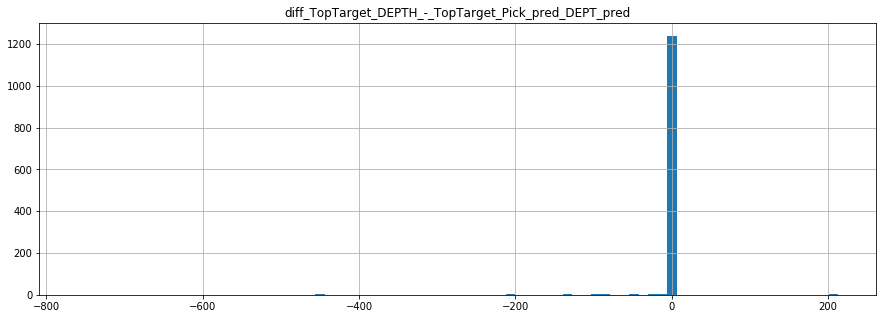

In [250]:
r2,mean_absolute_error_,df_calc_pred_Top_Pick_pred_DEPT_pred = rollToWell.run_all('TopTarget_Pick_pred_DEPT_pred','TopTarget_DEPTH')

examine results of train data version..

In [345]:
len(df_calc_pred_Top_Pick_pred_DEPT_pred)

1280

In [252]:
df_calc_pred_Top_Pick_pred_DEPT_pred[300:400]

,UWI,TopTarget_Pick_pred_DEPT_pred,diff_TopTarget_DEPTH_-_TopTarget_Pick_pred_DEPT_pred,TopTarget_DEPTH
300,00/07-04-086-17W4/0,233.171,0.309,233.48
301,00/07-04-087-25W4/0,439.100,0.420,439.52
302,00/07-06-069-09W4/0,630.000,0.000,630.00
303,00/07-06-072-25W4/0,592.692,0.448,593.14
304,00/07-06-079-03W4/0,295.500,0.000,295.50
305,00/07-06-080-06W4/0,291.000,0.000,291.00
306,00/07-06-083-03W4/0,227.500,0.000,227.50
307,00/07-06-083-04W4/0,209.001,0.499,209.50
308,00/07-07-067-16W4/0,545.798,0.402,546.20
309,00/07-07-069-12W4/0,460.000,0.000,460.00


In [253]:
r2

0.873268894588701

In [254]:
mean_absolute_error_

7.606963281249952

In [336]:
train_list = df_calc_pred_Top_Pick_pred_DEPT_pred['diff_TopTarget_DEPTH_-_TopTarget_Pick_pred_DEPT_pred'].tolist()

In [337]:
len(train_list)

1280

In [338]:
test_list_short = []
for item in test_list:
    if item > 3:
        test_list_short.append(item)
len(test_list_short)

14

### Now TEST data version

In [339]:
distClassDF_wRollingCols_testData.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456,0.0,0.0,0.0,0.0,449.474,361.363636
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206,0.0,0.0,0.0,0.0,449.474,361.363636
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956,0.0,0.0,0.0,0.0,449.474,361.363636
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706,0.0,0.0,0.0,0.0,449.474,361.363636
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456,0.0,0.0,0.0,0.0,449.474,361.363636


In [340]:

rollToWell_test = accuracy_singleTopPerWellPrediction_fromRollingRules(ML1,vs,distClassDF_wRollingCols_testData)

1
2
4
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'str'>
<class 'str'>


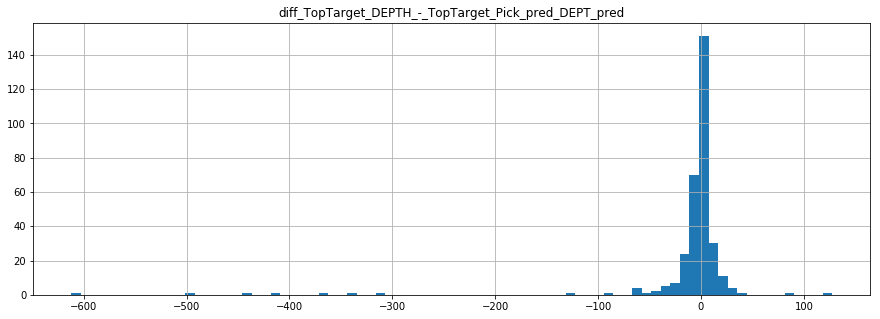

In [341]:
r2_testData,mean_absolute_error_testData,df_calc_pred_Top_Pick_pred_DEPT_pred_testData = rollToWell_test.run_all('TopTarget_Pick_pred_DEPT_pred','TopTarget_DEPTH')


examine results of test data version

In [358]:
r2_testData

0.846861575770373

In [359]:
mean_absolute_error_testData

18.366585669781934

In [344]:
df_calc_pred_Top_Pick_pred_DEPT_pred_testData.head()

,UWI,TopTarget_Pick_pred_DEPT_pred,diff_TopTarget_DEPTH_-_TopTarget_Pick_pred_DEPT_pred,TopTarget_DEPTH
0,00/01-04-075-23W4/0,624.500,6.500,631.0
1,00/01-12-079-14W4/0,454.000,0.000,454.0
2,00/01-25-083-02W4/0,196.000,24.500,220.5
3,00/01-27-079-23W4/0,429.000,12.000,441.0
4,00/02-05-076-26W4/0,792.898,13.602,806.5


## The prediction are off in large part because a few wells have no prediction at all, which is treated as a zero! In real life, we would happily know we can't predict those wells with this model (by virtue of getting a zero for them) and ignore them, so let's use that in our stats too!

# This is accuracy of prediction for each well of test dataset but excludes the few wells that only have zeros predicted for distance class at every point!!

In [380]:
rollToWell_test_noZeros = accuracy_singleTopPerWellPrediction_fromRollingRules(ML1,vs,distClassDF_wRollingCols_testData)

hit yes in optionallyExcludeWellsWithoutStrongPredictions()
1
2
4
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'str'>
<class 'str'>


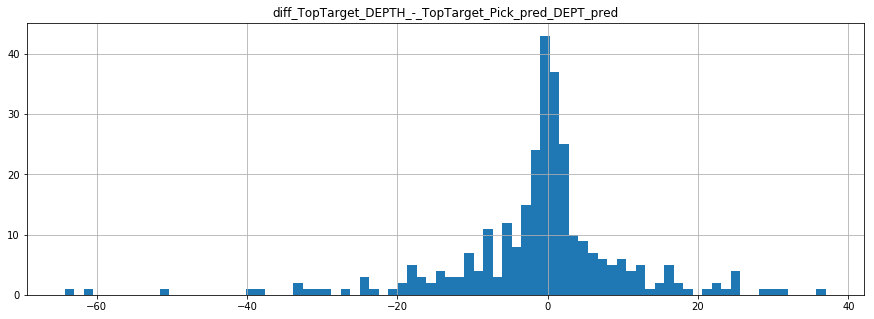

In [381]:
r2_testData_NoZeros,mean_absolute_error_testData_NoZeros,df_calc_pred_Top_Pick_pred_DEPT_pred_testData_NoZeros = rollToWell_test_noZeros.run_all('TopTarget_Pick_pred_DEPT_pred','TopTarget_DEPTH',keepAllWells="yes",dropIfOnlyClasses=[0])


In [382]:
r2_testData_NoZeros

0.9947379948764857

In [383]:
mean_absolute_error_testData_NoZeros

7.4610761589402825

In [385]:
rollToWell_test_noZeros.precentWellsKept

0.940809968847352

# STOPPED WORKING JUST ABOVE HERE

THe quality controls are (-1) no pick, pick is unknown, or no data available, (0) pick is missing or eroded, high degree of condience based on a complete dataset and log suite, (1) good pick, with a high degree of condience based on geophysical log correlation and core control, (2) pick is highly interpretitve, but confirmed by surrounding wells (3) pick is uncertain, due to poor or missing data and/or low degree of confidence in correlation, and (4) pick is based on primary on drillers logs or other reliable drilling information.

# Now let's try that with ML instead of taking that max sum mean column thingy

In [169]:
calc_pred[680:780]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
680,0,70,00/10-27-076-11W4/0,test,0,446.23,438.224,507.0,54.5,445.68,7.456,70.00,70.000000,54.090909,264.090909,449.474,361.363636
681,0,70,00/10-27-076-11W4/0,test,0,446.23,438.474,507.0,54.5,445.68,7.206,70.00,70.000000,57.272727,267.272727,449.474,361.363636
682,0,70,00/10-27-076-11W4/0,test,0,446.23,438.724,507.0,54.5,445.68,6.956,70.00,70.000000,60.454545,270.454545,449.474,361.363636
683,0,70,00/10-27-076-11W4/0,test,0,446.23,438.974,507.0,54.5,445.68,6.706,70.00,70.000000,63.636364,273.636364,449.474,361.363636
684,0,70,00/10-27-076-11W4/0,test,0,446.23,439.224,507.0,54.5,445.68,6.456,70.00,70.000000,66.818182,276.818182,449.474,361.363636
685,0,70,00/10-27-076-11W4/0,test,0,446.23,439.474,507.0,54.5,445.68,6.206,70.00,70.000000,70.000000,280.000000,449.474,361.363636
686,0,70,00/10-27-076-11W4/0,test,0,446.23,439.724,507.0,54.5,445.68,5.956,70.00,70.000000,70.000000,280.000000,449.474,361.363636
687,0,70,00/10-27-076-11W4/0,test,0,446.23,439.974,507.0,54.5,445.68,5.706,70.00,70.000000,70.000000,280.000000,449.474,361.363636
688,0,70,00/10-27-076-11W4/0,test,0,446.23,440.224,507.0,54.5,445.68,5.456,70.00,70.000000,70.000000,280.000000,449.474,361.363636
689,0,70,00/10-27-076-11W4/0,test,0,446.23,440.474,507.0,54.5,445.68,5.206,70.00,70.000000,70.000000,280.000000,449.474,361.363636


In [180]:
###len(calc_pred)

1. regression to predict distance between actual pick and each depth, then finding max for each well
2. regression, same as 1 but only for top 20 predictions in each well?
3. Class prediction, one pick per well and class is pick or not pick..but then still left with multiple per well?

## Part 2b: First step, run the rolling mean etc. functions on the train dataset

In [181]:
df_results_train_.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [182]:
df_results_train_wIndex = pd.concat([df_results_train_, train_index], axis=1)

In [183]:
df_results_train_wIndex[2200:2300]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH
2200,60,60,00/11-30-073-13W4/0,train,60,504.00
2201,60,60,00/11-30-073-13W4/0,train,60,504.00
2202,60,60,00/11-30-073-13W4/0,train,60,504.00
2203,60,60,00/11-30-073-13W4/0,train,60,504.00
2204,60,60,00/11-30-073-13W4/0,train,60,504.00
2205,60,60,00/11-30-073-13W4/0,train,60,504.00
2206,60,60,00/11-30-073-13W4/0,train,60,504.00
2207,60,60,00/11-30-073-13W4/0,train,60,504.00
2208,60,60,00/11-30-073-13W4/0,train,60,504.00
2209,60,60,00/11-30-073-13W4/0,train,60,504.00


In [184]:
df_results_train_wIndex = pd.concat([df_results_train_wIndex, train_X[['DEPT',"NN1_TopHelper_DEPTH","NN1_thickness","topTarget_Depth_predBy_NN1thick","DistFrom_NN1ThickPredTopDepth_toRowDept"]]], axis=1)

In [185]:
df_results_train_wIndex[470:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept
470,70,70,00/11-19-073-16W4/0,train,70,422.76,419.994,446.84,23.78,421.84,1.846
471,70,70,00/11-19-073-16W4/0,train,70,422.76,420.244,446.84,23.78,421.84,1.596
472,70,70,00/11-19-073-16W4/0,train,70,422.76,420.494,446.84,23.78,421.84,1.346
473,70,70,00/11-19-073-16W4/0,train,70,422.76,420.744,446.84,23.78,421.84,1.096
474,70,70,00/11-19-073-16W4/0,train,70,422.76,420.994,446.84,23.78,421.84,0.846
475,70,95,00/11-19-073-16W4/0,train,70,422.76,421.244,446.84,23.78,421.84,0.596
476,70,100,00/11-19-073-16W4/0,train,70,422.76,421.494,446.84,23.78,421.84,0.346
477,70,95,00/11-19-073-16W4/0,train,70,422.76,421.744,446.84,23.78,421.84,0.096
478,70,95,00/11-19-073-16W4/0,train,70,422.76,421.994,446.84,23.78,421.84,0.154
479,70,95,00/11-19-073-16W4/0,train,70,422.76,422.244,446.84,23.78,421.84,0.404


In [186]:
def calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
    """
    Function takes in:
        A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
    Function returns:
        A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
        A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
    THESE BELOW ARE NOTE YET IMPLIMENTED!    
        A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
        A new col in the new df that has high and low error by some metric?
        A score of mean abosolute error across all wells in the given dataframe 1.
    """

    df_merges = df.copy()
    all_new_rolling_mean_col = []
    for Window in rollingWindows:
        new_col = pick_pred_class_str+'_classRollMean'+str(Window)
        all_new_rolling_mean_col.append(new_col)
        half_window_neg = -1*math.floor(Window/2)
        df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
    df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
    for col in all_new_rolling_mean_col:
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
    df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
    idx = df_merges.loc[df_merges.groupby([UWI_str])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
    #print('idx=',idx)
    print('type(idx)',type(idx))
#     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
    max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
    print("columns of max_frame are:",max_frame.columns)
    max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'_classRollMeanSum']
    #print("type",type(max_series),"and max series is ",max_series)
    print("columns of df_merges are:",df_merges.columns)
    print("columns of max_frame are:",max_frame.columns)
    df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_merges
    

In [187]:
len(df_results_train_wIndex)

217602

In [188]:
calc_pred_train = calcPredVsRealTopDif(df_results_train_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])

type(idx) <class 'pandas.core.frame.DataFrame'>
columns of max_frame are: Index(['UWI', 'DEPT', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of df_merges are: Index(['class_DistFrPick_TopTarget', 'TopTarget_Pick_pred', 'UWI', 'trainOrTest', 'class_DistFrPick_TopTarget', 'TopTarget_DEPTH', 'DEPT', 'NN1_TopHelper_DEPTH', 'NN1_thickness', 'topTarget_Depth_predBy_NN1thick', 'DistFrom_NN1ThickPredTopDepth_toRowDept', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of max_frame are: Index(['UWI', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum'], dtype='object')


In [189]:
calc_pred_train[460:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
460,60,60,00/07-23-076-22W4/0,train,60,630.33,634.364,658.98,24.39,623.01,11.354,60.00,60.000000,66.136364,246.136364,629.864,380.454545
461,60,60,00/07-23-076-22W4/0,train,60,630.33,634.614,658.98,24.39,623.01,11.604,60.00,60.000000,67.727273,247.727273,629.864,380.454545
462,60,60,00/07-23-076-22W4/0,train,60,630.33,634.864,658.98,24.39,623.01,11.854,60.00,60.000000,67.727273,247.727273,629.864,380.454545
463,60,60,00/07-23-076-22W4/0,train,60,630.33,635.114,658.98,24.39,623.01,12.104,60.00,65.833333,67.727273,253.560606,629.864,380.454545
464,0,60,00/07-23-076-22W4/0,train,0,630.33,635.364,658.98,24.39,623.01,12.354,68.75,55.833333,67.727273,252.310606,629.864,380.454545
465,0,60,00/07-23-076-22W4/0,train,0,630.33,637.864,658.98,24.39,623.01,14.854,53.75,45.833333,67.727273,227.310606,629.864,380.454545
466,0,95,00/07-23-076-22W4/0,train,0,630.33,640.364,658.98,24.39,623.01,17.354,38.75,35.833333,67.727273,237.310606,629.864,380.454545
467,0,0,00/07-23-076-22W4/0,train,0,630.33,642.864,658.98,24.39,623.01,19.854,23.75,41.666667,67.727273,133.143939,629.864,380.454545
468,0,0,00/07-23-076-22W4/0,train,0,630.33,645.364,658.98,24.39,623.01,22.354,23.75,47.500000,69.318182,140.568182,629.864,380.454545
469,0,0,00/07-23-076-22W4/0,train,0,630.33,647.864,658.98,24.39,623.01,24.854,47.50,47.500000,70.909091,165.909091,629.864,380.454545


## THERE IS SOMETHING WRONG IN HERE WHEN I TRY TO USE THE TRAIN DATAFRAME! I GET REPEATS IN THE DEPTH COLUMNS AT THE DEPTH OF THE PICK! AND I CAN"T FIGURE OUT WHY FOR NOW I"M TAKING THEM OUT MANUALLY!

In [190]:
len(calc_pred)

255885

In [191]:
len(calc_pred_train)

217602

In [192]:
# calc_pred_train['DEPT_shift'] = calc_pred_train['DEPT'].shift(+1)
# calc_pred_train['DEPT_shiftDistInDepth'] = calc_pred_train['DEPT']-calc_pred_train['DEPT_shift']
# calc_pred_train['DEPT_shiftDistInDepth'].abs()
# calc_pred_train['DEPT_diff]
# calc_pred_train['UWI_shiftDown'] = calc_pred_train['UWI'].shift(+1)


In [193]:
calc_pred_train.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,414.0,25.0,359.66,210.058,0.0,0.0,0.0,0.0,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,414.0,25.0,359.66,207.558,0.0,0.0,0.0,0.0,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,414.0,25.0,359.66,205.058,0.0,0.0,0.0,0.0,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,414.0,25.0,359.66,202.558,0.0,0.0,0.0,0.0,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,414.0,25.0,359.66,200.058,0.0,0.0,0.0,0.0,377.602,384.848485


In [194]:
# calc_pred_train['DEPT_shiftDistInDepth'].value_counts()

### Nevermind, I forgot I doubled the rows for certain depths to rebalance the columns!!!! duh!!

In [195]:
calc_pred_train_TopMcMr_Pick_pred_DEPT_pred = calc_pred_train.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
calc_pred_train_TopTarget_DEPTH = calc_pred_train.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()

In [196]:
calc_pred_train.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,414.0,25.0,359.66,210.058,0.0,0.0,0.0,0.0,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,414.0,25.0,359.66,207.558,0.0,0.0,0.0,0.0,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,414.0,25.0,359.66,205.058,0.0,0.0,0.0,0.0,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,414.0,25.0,359.66,202.558,0.0,0.0,0.0,0.0,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,414.0,25.0,359.66,200.058,0.0,0.0,0.0,0.0,377.602,384.848485


In [197]:
calc_pred_train_TopMcMr_Pick_pred_DEPT_pred.head()

,UWI,TopTarget_Pick_pred_DEPT_pred
0,00/01-01-073-05W5/0,607.000
1,00/01-03-085-15W4/0,242.501
2,00/01-05-085-15W4/0,253.000
3,00/01-08-080-21W4/0,411.000
4,00/01-09-080-13W4/0,441.000


In [198]:
calc_pred_train_TopTarget_DEPTH.head()

,UWI,TopTarget_DEPTH
0,00/01-01-073-05W5/0,607.0
1,00/01-03-085-15W4/0,243.0
2,00/01-05-085-15W4/0,253.0
3,00/01-08-080-21W4/0,411.0
4,00/01-09-080-13W4/0,441.0


In [199]:
type(calc_pred_train_TopTarget_DEPTH)

pandas.core.frame.DataFrame

In [200]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [201]:
# r2_score_train_wZeros = r2_score(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
# r2_score_train_wZeros

r2_score_train_wZeros = r2_score(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
r2_score_train_wZeros

0.873268894588701

In [202]:
mean_absolute_error_train_wZeros = mean_absolute_error(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
mean_absolute_error_train_wZeros

7.606963281249952

## Part 2b: First step appendum: Add column for regression target of distance between depth and real pick depth

In [203]:

calc_pred_train['TopTarget_DEPTH_minus_DEPT'] = calc_pred_train['TopTarget_DEPTH'] - calc_pred_train['DEPT']

In [204]:
calc_pred_train[2740:2750]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_DEPTH_minus_DEPT
2740,95,70,00/06-08-074-11W4/0,train,95,472.44,471.954,522.0,53.0,479.18,7.226,82.50,82.500000,82.500000,317.500000,472.204,380.227273,0.486
2741,95,95,00/06-08-074-11W4/0,train,95,472.44,472.204,522.0,53.0,479.18,6.976,88.75,86.666667,83.636364,354.053030,472.204,380.227273,0.236
2742,95,95,00/06-08-074-11W4/0,train,95,472.44,472.454,522.0,53.0,479.18,6.726,95.00,90.833333,84.772727,365.606061,472.204,380.227273,-0.014
2743,95,95,00/06-08-074-11W4/0,train,95,472.44,472.704,522.0,53.0,479.18,6.476,95.00,95.000000,85.909091,370.909091,472.204,380.227273,-0.264
2744,60,95,00/06-08-074-11W4/0,train,60,472.44,472.954,522.0,53.0,479.18,6.226,95.00,95.000000,85.454545,370.454545,472.204,380.227273,-0.514
2745,60,95,00/06-08-074-11W4/0,train,60,472.44,473.204,522.0,53.0,479.18,5.976,95.00,95.000000,85.000000,370.000000,472.204,380.227273,-0.764
2746,60,95,00/06-08-074-11W4/0,train,60,472.44,473.454,522.0,53.0,479.18,5.726,95.00,95.000000,84.545455,369.545455,472.204,380.227273,-1.014
2747,60,95,00/06-08-074-11W4/0,train,60,472.44,473.704,522.0,53.0,479.18,5.476,95.00,95.000000,84.090909,369.090909,472.204,380.227273,-1.264
2748,60,95,00/06-08-074-11W4/0,train,60,472.44,473.954,522.0,53.0,479.18,5.226,95.00,95.000000,83.636364,368.636364,472.204,380.227273,-1.514
2749,60,95,00/06-08-074-11W4/0,train,60,472.44,474.204,522.0,53.0,479.18,4.976,95.00,95.000000,84.772727,369.772727,472.204,380.227273,-1.764


## Part 2b: Second step, train model for train dataset

### Let's make a column for top predicted pick depth from rolling mean minus each row depth

In [205]:

calc_pred_train['TopTarget_Pick_pred_DEPT_pred_minus_DEPT'] = calc_pred_train['TopTarget_Pick_pred_DEPT_pred'] - calc_pred_train['DEPT']

In [206]:
#calc_pred_train.drop(['TopTarget_DEPTH_minus_TopTarget_DEPTH'],axis=1)

In [207]:
calc_pred_train[3300:3400]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_DEPTH_minus_DEPT,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
3300,60,70,00/11-23-080-04W4/0,train,60,259.99,261.821,275.23,79.24,263.66,1.839,65.00,65.000000,73.863636,273.863636,259.688,382.537879,-1.831,-2.133
3301,60,60,00/11-23-080-04W4/0,train,60,259.99,262.126,275.23,79.24,263.66,1.534,62.50,63.333333,70.681818,256.515152,259.688,382.537879,-2.136,-2.438
3302,60,60,00/11-23-080-04W4/0,train,60,259.99,262.431,275.23,79.24,263.66,1.229,60.00,61.666667,67.500000,249.166667,259.688,382.537879,-2.441,-2.743
3303,60,60,00/11-23-080-04W4/0,train,60,259.99,262.736,275.23,79.24,263.66,0.924,60.00,60.000000,63.181818,243.181818,259.688,382.537879,-2.746,-3.048
3304,60,60,00/11-23-080-04W4/0,train,60,259.99,263.040,275.23,79.24,263.66,0.620,60.00,60.000000,58.863636,238.863636,259.688,382.537879,-3.050,-3.352
3305,60,60,00/11-23-080-04W4/0,train,60,259.99,263.345,275.23,79.24,263.66,0.315,60.00,65.833333,54.545455,240.378788,259.688,382.537879,-3.355,-3.657
3306,60,60,00/11-23-080-04W4/0,train,60,259.99,263.650,275.23,79.24,263.66,0.010,68.75,71.666667,50.227273,250.643939,259.688,382.537879,-3.660,-3.962
3307,60,60,00/11-23-080-04W4/0,train,60,259.99,263.955,275.23,79.24,263.66,0.295,77.50,71.666667,45.909091,255.075758,259.688,382.537879,-3.965,-4.267
3308,60,95,00/11-23-080-04W4/0,train,60,259.99,264.260,275.23,79.24,263.66,0.600,77.50,71.666667,42.727273,286.893939,259.688,382.537879,-4.270,-4.572
3309,60,95,00/11-23-080-04W4/0,train,60,259.99,264.565,275.23,79.24,263.66,0.905,77.50,61.666667,39.545455,273.712121,259.688,382.537879,-4.575,-4.877


In [453]:
len(calc_pred_train)

217602

In [454]:
columnsDoNotNeedFor2ML = ['TopTarget_Pick_pred','NN1_TopHelper_DEPTH','topTarget_Depth_predBy_NN1thick','class_DistFrPick_TopTarget','trainOrTest','UWI','class_DistFrPick_TopTarget','TopTarget_DEPTH','DEPT','TopTarget_DEPTH_minus_DEPT']

columnsLabels2ML = ['UWI','trainOrTest','DEPT']
calc_pred_train_forMLtrain = calc_pred_train.drop(columnsDoNotNeedFor2ML,axis=1)

In [455]:
##columnsLabels2ML = ['UWI','trainOrTest','DEPT']

In [456]:
##calc_pred_train_forMLtrain = calc_pred_train.drop(columnsDoNotNeedFor2ML,axis=1)


In [457]:
calc_pred_train_forMLtrain_indexLabels = calc_pred_train[columnsLabels2ML]
# 

In [458]:
calc_pred_train_forMLtrain[200:400]

,NN1_thickness,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
200,47.55,122.680,0.00,0.000000,0.000000,0.000000,423.840,381.515152,116.75
201,47.55,120.180,0.00,0.000000,0.000000,0.000000,423.840,381.515152,114.25
202,47.55,117.680,0.00,0.000000,0.000000,0.000000,423.840,381.515152,111.75
203,47.55,115.180,0.00,0.000000,0.000000,0.000000,423.840,381.515152,109.25
204,47.55,112.680,0.00,0.000000,0.000000,0.000000,423.840,381.515152,106.75
205,47.55,110.180,0.00,0.000000,0.000000,0.000000,423.840,381.515152,104.25
206,47.55,107.680,0.00,0.000000,0.000000,0.000000,423.840,381.515152,101.75
207,47.55,105.180,0.00,0.000000,0.000000,0.000000,423.840,381.515152,99.25
208,47.55,102.680,0.00,0.000000,0.000000,0.000000,423.840,381.515152,96.75
209,47.55,100.180,0.00,0.000000,0.000000,0.000000,423.840,381.515152,94.25


In [459]:
len(calc_pred_train_forMLtrain)

217602

In [460]:
calc_pred_train_forMLtarget = calc_pred_train[['TopTarget_DEPTH_minus_DEPT']]

In [461]:
calc_pred_train_forMLtarget.head()

,TopTarget_DEPTH_minus_DEPT
0,228.348
1,225.848
2,223.348
3,220.848
4,218.348


In [462]:
len(calc_pred_train_forMLtarget)

217602

## Part 2b:: Fourth step, predict using test dataset

In [463]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456


## Part 2b: Third step, predict using train dataset

In [464]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [465]:
calc_pred_train_forMLtrain

,NN1_thickness,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
0,25.00,210.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485,228.00
1,25.00,207.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485,225.50
2,25.00,205.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485,223.00
3,25.00,202.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485,220.50
4,25.00,200.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485,218.00
5,25.00,197.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485,215.50
6,25.00,195.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485,213.00
7,25.00,192.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485,210.50
8,25.00,190.058,0.00,0.000000,0.000000,0.000000,377.602,384.848485,208.00
9,25.00,187.558,0.00,0.000000,0.000000,0.000000,377.602,384.848485,205.50


In [466]:
calc_pred_train_forMLtarget

,TopTarget_DEPTH_minus_DEPT
0,228.348
1,225.848
2,223.348
3,220.848
4,218.348
5,215.848
6,213.348
7,210.848
8,208.348
9,205.848


In [467]:
len(calc_pred_train_forMLtarget)

217602

In [468]:
X = calc_pred_train_forMLtrain.values
Y = calc_pred_train_forMLtarget['TopTarget_DEPTH_minus_DEPT'].values.ravel()

In [469]:
len(X)

217602

In [470]:
len(Y)

217602

In [471]:
seed = 7
#test_size = 0.10
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed)

In [472]:
modelR = XGBRegressor()


In [473]:
modelR.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [474]:
y_pred = modelR.predict(X_train)

In [475]:
y_pred

array([4.6500391e-01, 5.7621449e-02, 9.7235054e+01, ..., 2.0057736e+02,
       1.4656578e+02, 5.7621449e-02], dtype=float32)

In [476]:
y_pred.mean()

22.621708

In [477]:
y_test.mean()

22.762741383430452

In [478]:
y_test[0]

0.0

In [479]:
y_pred[0]

0.4650039

In [480]:
y_test[100]

0.75

In [481]:
y_pred[100]

0.05762145

In [482]:
test_pred_dist_diff = y_train - y_pred

In [483]:
len(y_test)

54401

In [484]:
len(y_pred)

163201

In [485]:
import matplotlib.pyplot as plt

The plot is: For each row, the distance between the predicted distance between that row's depth and the actual pick depth in that row 

but only for training data that was used in this regression model

(array([3.3000e+01, 2.7000e+01, 2.3000e+01, 1.9000e+01, 2.8000e+01,
        2.8000e+01, 2.7000e+01, 2.5000e+01, 3.4000e+01, 3.7000e+01,
        3.6000e+01, 4.3000e+01, 5.4000e+01, 4.6000e+01, 4.4000e+01,
        9.3000e+01, 1.9900e+02, 2.8200e+02, 2.5800e+02, 4.3100e+02,
        8.1100e+02, 1.1220e+03, 1.4510e+03, 2.1860e+03, 2.5780e+03,
        3.2270e+03, 4.3040e+03, 6.4520e+03, 1.3509e+04, 6.3778e+04,
        2.2296e+04, 1.0884e+04, 6.4330e+03, 5.2310e+03, 4.4870e+03,
        3.4770e+03, 2.6620e+03, 1.5500e+03, 1.2390e+03, 8.1300e+02,
        4.6900e+02, 3.1200e+02, 1.5400e+02, 8.8000e+01, 5.2000e+01,
        4.2000e+01, 4.4000e+01, 2.8000e+01, 3.4000e+01, 2.6000e+01,
        2.6000e+01, 2.5000e+01, 2.6000e+01, 1.4000e+01, 1.9000e+01,
        2.1000e+01, 1.4000e+01, 1.9000e+01, 2.6000e+01, 2.8000e+01]),
 array([-10.        ,  -9.66666667,  -9.33333333,  -9.        ,
         -8.66666667,  -8.33333333,  -8.        ,  -7.66666667,
         -7.33333333,  -7.        ,  -6.66666667,  -6.

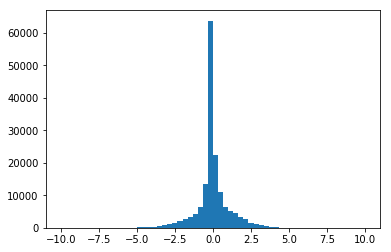

In [486]:
plt.hist(test_pred_dist_diff, bins=60,range=[-10, 10])

## Functions to take results append them to a dataframe with more columns like depth and actual pick depth and then run accuracy results on a per well instead of per row basis

In [487]:
#len(y_pred)

In [488]:
#len(y_test)

In [489]:
#len(test_y)

In [490]:
# train_y_indexValues = train_y.index.values
# df_result_train = pd.DataFrame(result_train, index=train_y_indexValues, columns=['TopTarget_Pick_pred'])
# df_results_train_ = pd.concat([train_y, df_result_train], axis=1)
#y_test_indexValues = y_test.index.values
#df_result_test = pd.DataFrame(y_pred, index=y_test_indexValues, columns=['TopTarget_RegPred_DistFromPick'])
#df_results_test_reg = pd.concat([y_test, df_result_train], axis=1)


# Process test dataset for this

In [491]:
def prepFor2ndMLonTest(df_results_test_wIndex,columnsDoNotNeedFor2ML):
    calc_pred_test = calcPredVsRealTopDif(df_results_test_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])
    calc_pred_test_TopMcMr_Pick_pred_DEPT_pred = calc_pred_test.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
    calc_pred_test_TopTarget_DEPTH = calc_pred_test.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()
    r2_score_test_wZeros = r2_score(calc_pred_test_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_test_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
    print("r2_score_test_wZeros = ",r2_score_test_wZeros)
    mean_absolute_error_test_wZeros = mean_absolute_error(calc_pred_test_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_test_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
    print("mean_absolute_error_test_wZeros",mean_absolute_error_test_wZeros)
    ####
    calc_pred_test['TopTarget_DEPTH_minus_DEPT'] = calc_pred_test['TopTarget_DEPTH'] - calc_pred_test['DEPT']
    calc_pred_test['TopTarget_Pick_pred_DEPT_pred_minus_DEPT'] = calc_pred_test['TopTarget_Pick_pred_DEPT_pred'] - calc_pred_test['DEPT']
    ####
    columnsLabels2ML = ['UWI','trainOrTest','DEPT']
    ####
    calc_pred_test_forMLtest = calc_pred_test.drop(columnsDoNotNeedFor2ML,axis=1)
    calc_pred_test_forMLtest_indexLabels = calc_pred_test[columnsLabels2ML]
    calc_pred_test_forMLtarget = calc_pred_test[['TopTarget_DEPTH_minus_DEPT']]
    ####
    print("print calc_pred_test_forMLtest.head()",calc_pred_test_forMLtest.head())
    Xtest = calc_pred_test_forMLtest.values
    Ytest = calc_pred_test_forMLtarget['TopTarget_DEPTH_minus_DEPT'].values.ravel()
    return Xtest,Ytest,calc_pred_test_forMLtest
#     seed = 7
#     test_size = 0.33
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
#     model = XGBRegressor()
#     model.fit(X,Y)

    
    

In [492]:
columnsDoNotNeedFor2ML

['TopTarget_Pick_pred',
 'NN1_TopHelper_DEPTH',
 'topTarget_Depth_predBy_NN1thick',
 'class_DistFrPick_TopTarget',
 'trainOrTest',
 'UWI',
 'class_DistFrPick_TopTarget',
 'TopTarget_DEPTH',
 'DEPT',
 'TopTarget_DEPTH_minus_DEPT']

In [493]:
Xtest,Ytest,calc_pred_test_forMLtest = prepFor2ndMLonTest(df_results_test_wIndex,columnsDoNotNeedFor2ML)

type(idx) <class 'pandas.core.frame.DataFrame'>
columns of max_frame are: Index(['UWI', 'DEPT', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of df_merges are: Index(['class_DistFrPick_TopTarget', 'TopTarget_Pick_pred', 'UWI', 'trainOrTest', 'class_DistFrPick_TopTarget', 'TopTarget_DEPTH', 'DEPT', 'NN1_TopHelper_DEPTH', 'NN1_thickness', 'topTarget_Depth_predBy_NN1thick', 'DistFrom_NN1ThickPredTopDepth_toRowDept', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of max_frame are: Index(['UWI', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum'], dtype='object')
r2_score_test_wZeros =  0.846861575770373
mean_absolute_error_test_wZeros 18.366585669781934
print calc_pred_test_forMLtest.head()    NN1_thickness  DistFrom_NN1ThickPredTopDepth_toRowDept  TopTarget_Pick_pred_classRollMean4  TopTarget_Pick_pred_classRollMean6  To

In [494]:
print(len(Xtest),len(Ytest))

255885 255885


In [495]:
calc_pred_test_forMLtest[600:900]

,NN1_thickness,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
600,54.5,27.456,0.00,0.000000,0.000000,0.000000,449.474,361.363636,31.25
601,54.5,27.206,0.00,0.000000,0.000000,0.000000,449.474,361.363636,31.00
602,54.5,26.956,0.00,0.000000,0.000000,0.000000,449.474,361.363636,30.75
603,54.5,26.706,0.00,0.000000,0.000000,0.000000,449.474,361.363636,30.50
604,54.5,26.456,0.00,0.000000,0.000000,0.000000,449.474,361.363636,30.25
605,54.5,26.206,0.00,0.000000,0.000000,0.000000,449.474,361.363636,30.00
606,54.5,25.956,0.00,0.000000,0.000000,0.000000,449.474,361.363636,29.75
607,54.5,25.706,0.00,0.000000,0.000000,0.000000,449.474,361.363636,29.50
608,54.5,25.456,0.00,0.000000,0.000000,0.000000,449.474,361.363636,29.25
609,54.5,25.206,0.00,0.000000,0.000000,0.000000,449.474,361.363636,29.00


In [496]:
calc_pred_test_forMLtest.columns

Index(['NN1_thickness', 'DistFrom_NN1ThickPredTopDepth_toRowDept', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum', 'TopTarget_Pick_pred_DEPT_pred_minus_DEPT'], dtype='object')

In [497]:
calc_pred_train_forMLtrain_columns = calc_pred_train_forMLtrain.columns
calc_pred_train_forMLtrain_columns

Index(['NN1_thickness', 'DistFrom_NN1ThickPredTopDepth_toRowDept', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum', 'TopTarget_Pick_pred_DEPT_pred_minus_DEPT'], dtype='object')

In [498]:
def runModel2Predict(model,Xtest,Ytest):    
    test_pred = model.predict(Xtest)
    test_pred_dist_diff = Ytest - test_pred
    print("mean_absolute_error",mean_absolute_error(test_pred, Ytest))
    return test_pred_dist_diff,  test_pred

In [499]:
testtest_pred_dist_diff, test_pred = runModel2Predict(modelR,Xtest,Ytest)

mean_absolute_error 8.300713682933127


In [500]:
testtest_pred_dist_diff[700:800]

array([-3.06155781, -3.31155781, -3.56155781, -3.07755761, -2.67828946,
       -2.92828946, -3.17828946, -3.42828946, -3.67828946, -2.70202426,
       -2.95202426, -3.20202426, -2.92075018, -3.17075018, -3.42075018,
       -3.14187459, -3.11741642, -3.36741642, -2.92131845, -3.17131845,
       -3.0181431 , -3.2681431 , -3.21620308, -3.20900391, -3.25537638,
       -3.30162145, -3.45127223, -3.70127223, -3.68650864, -3.48564522,
       -3.73564522, -3.56266729, -3.81266729, -3.55258374, -3.80258374,
       -4.05258374, -3.49027066, -3.67623643, -3.73448424, -3.55520205,
       -3.80520205, -3.47738795, -3.46807198, -3.59932999, -3.84932999,
       -4.09932999, -4.03186659, -4.28186659, -3.07841782, -3.32841782,
       -3.57841782, -3.82841782, -4.07841782, -4.32841782, -4.57841782,
       -5.07106881, -3.48935561, -3.73935561, -1.37242846, -1.62242846,
       -1.87242846, -1.98376707, -2.23376707, -2.48376707, -2.73376707,
       -2.98376707, -3.23376707, -3.48376707, -3.73376707, -3.98

In [501]:
testtest_pred_dist_diff

array([-3.98589758, -1.73170142, -1.98170142, ..., 14.22988397,
       13.97988397, 13.72988397])

In [502]:
len(testtest_pred_dist_diff)

255885

In [503]:
len(test_pred)

255885

(array([2.0800e+02, 5.5000e+01, 4.1000e+01, 3.6000e+01, 1.0500e+02,
        3.1200e+02, 7.2600e+02, 5.0400e+02, 1.9600e+02, 3.6500e+02,
        9.8400e+02, 1.4450e+03, 1.4120e+03, 1.0510e+03, 8.6300e+02,
        1.1770e+03, 9.8500e+02, 1.3020e+03, 2.5130e+03, 3.6510e+03,
        3.4370e+03, 3.8510e+03, 4.0850e+03, 5.6710e+03, 7.3610e+03,
        8.5560e+03, 1.0274e+04, 1.3186e+04, 2.1045e+04, 3.1617e+04,
        3.6164e+04, 2.5325e+04, 1.3221e+04, 8.0180e+03, 6.6730e+03,
        6.3470e+03, 5.2590e+03, 3.7840e+03, 2.8140e+03, 3.3330e+03,
        2.4850e+03, 1.4860e+03, 1.4310e+03, 1.8400e+03, 2.2870e+03,
        1.0620e+03, 4.7500e+02, 7.6100e+02, 8.4000e+02, 3.8300e+02,
        1.6900e+02, 3.1000e+02, 3.4200e+02, 1.3100e+02, 5.0000e+01,
        3.1000e+01, 1.8000e+01, 1.1000e+01, 1.0000e+01, 1.8000e+01]),
 array([-50.        , -48.33333333, -46.66666667, -45.        ,
        -43.33333333, -41.66666667, -40.        , -38.33333333,
        -36.66666667, -35.        , -33.33333333, -31.

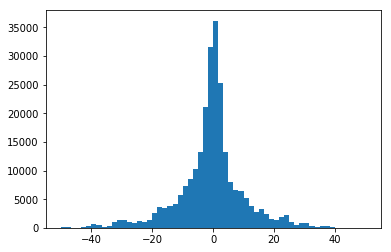

In [504]:
plt.hist(testtest_pred_dist_diff, bins=60,range=[-50, 50])

In [505]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456


In [506]:
len(df_results_test_wIndex)

255885

In [507]:
len(df_result_testtest)

255885

In [508]:
df_results_test_wIndexVal = df_results_test_wIndex.index.values
df_results_test_wIndex_wTestPredDistReg = pd.DataFrame(test_pred, index=df_results_test_wIndexVal, columns=['TopTarget_Pred_RegressionDistDiffPred'])


In [509]:
df_results_test_wIndex_wTestPredDistReg.index.is_unique

True

In [510]:
df_results_test_wIndex.index.is_unique

True

In [511]:
###df_result_testtest_resetIndx = df_result_testtest.reset_index()

In [512]:
##type(df_result_testtest_resetIndx)

In [513]:
##df_result_testtest_resetIndx.index.is_unique

In [514]:
##len(df_result_testtest_resetIndx)

In [515]:
##len(df_result_testtest_resetIndx.index)

In [516]:
###type(df_result_testtest_resetIndx)

In [517]:
##df_result_testtest_resetIndx.head()

In [518]:
#.index.is_unique

In [519]:
df_results_test_wIndex_wTestPredDistReg.head()

,TopTarget_Pred_RegressionDistDiffPred
11203,181.991898
11204,179.487701
11205,179.487701
11206,179.487701
11207,179.487701


In [520]:
test_df_wRegDistDiffPred= pd.concat([df_results_test_wIndex, df_results_test_wIndex_wTestPredDistReg], axis=1)

In [521]:
test_df_wRegDistDiffPred[600:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pred_RegressionDistDiffPred
11803,0,0,00/10-27-076-11W4/0,test,0,446.23,418.224,507.0,54.5,445.68,27.456,30.376158
11804,0,0,00/10-27-076-11W4/0,test,0,446.23,418.474,507.0,54.5,445.68,27.206,30.376158
11805,0,0,00/10-27-076-11W4/0,test,0,446.23,418.724,507.0,54.5,445.68,26.956,30.376158
11806,0,0,00/10-27-076-11W4/0,test,0,446.23,418.974,507.0,54.5,445.68,26.706,30.376158
11807,0,0,00/10-27-076-11W4/0,test,0,446.23,419.224,507.0,54.5,445.68,26.456,30.376158
11808,0,0,00/10-27-076-11W4/0,test,0,446.23,419.474,507.0,54.5,445.68,26.206,30.376158
11809,0,0,00/10-27-076-11W4/0,test,0,446.23,419.724,507.0,54.5,445.68,25.956,30.376158
11810,0,0,00/10-27-076-11W4/0,test,0,446.23,419.974,507.0,54.5,445.68,25.706,30.376158
11811,0,0,00/10-27-076-11W4/0,test,0,446.23,420.224,507.0,54.5,445.68,25.456,30.376158
11812,0,0,00/10-27-076-11W4/0,test,0,446.23,420.474,507.0,54.5,445.68,25.206,30.376158


In [522]:
test_df_wRegDistDiffPred.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pred_RegressionDistDiffPred
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456,181.991898
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206,179.487701
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956,179.487701
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706,179.487701
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456,179.487701


In [523]:
test_df_wRegDistDiffPred[2400:2600]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pred_RegressionDistDiffPred
18621,0,0,00/05-09-070-05W4/0,test,0,478.0,485.75,556.0,79.0,463.0,22.75,-10.395001
18622,0,0,00/05-09-070-05W4/0,test,0,478.0,486.00,556.0,79.0,463.0,23.00,-10.395001
18623,0,60,00/05-09-070-05W4/0,test,0,478.0,486.25,556.0,79.0,463.0,23.25,-10.395001
18624,0,60,00/05-09-070-05W4/0,test,0,478.0,486.50,556.0,79.0,463.0,23.50,-10.395001
18625,0,60,00/05-09-070-05W4/0,test,0,478.0,486.75,556.0,79.0,463.0,23.75,-10.395001
18626,0,0,00/05-09-070-05W4/0,test,0,478.0,487.00,556.0,79.0,463.0,24.00,-10.395001
18627,0,0,00/05-09-070-05W4/0,test,0,478.0,487.25,556.0,79.0,463.0,24.25,-10.395001
18628,0,0,00/05-09-070-05W4/0,test,0,478.0,487.50,556.0,79.0,463.0,24.50,-10.395001
18629,0,0,00/05-09-070-05W4/0,test,0,478.0,487.75,556.0,79.0,463.0,24.75,-10.395001
18630,0,100,00/05-09-070-05W4/0,test,0,478.0,488.00,556.0,79.0,463.0,25.00,-10.395001


### Use .abs to change negative predicted distance from pick so that we can then look for closest to zero by returning a min index within each well

In [524]:
test_df_wRegDistDiffPred["TopTarget_Pred_RegressionDistDiffPred"] = test_df_wRegDistDiffPred["TopTarget_Pred_RegressionDistDiffPred"].abs()

In [525]:
def findMin_TopTarget_Pred_RegressionDistDiffPred_byWell(df_merges,ColToMin):
    idx = df_merges.loc[df_merges.groupby(["UWI"])[ColToMin].idxmin()] 
    print('type(idx)',type(idx))
    max_frame = idx[['UWI','DEPT',ColToMin]]
    max_frame.columns = ['UWI','TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred',ColToMin]
    #print("type",type(max_series),"and max series is ",max_series)
    df_mergesResult = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_mergesResult,max_frame

In [526]:
regression2ndMLRound_onTest, max_frame = findMin_TopTarget_Pred_RegressionDistDiffPred_byWell(test_df_wRegDistDiffPred,"TopTarget_Pred_RegressionDistDiffPred")

type(idx) <class 'pandas.core.frame.DataFrame'>


In [527]:
len(max_frame)

321

In [528]:
max_frame

,UWI,TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred,TopTarget_Pred_RegressionDistDiffPred
607954,00/01-04-075-23W4/0,624.750,0.042728
838022,00/01-12-079-14W4/0,454.250,0.042728
686722,00/01-25-083-02W4/0,196.000,0.057621
349127,00/01-27-079-23W4/0,429.250,0.042728
294173,00/02-05-076-26W4/0,793.148,0.042728
33074,00/02-07-076-13W4/0,513.750,0.042728
423077,00/02-22-071-22W4/0,595.750,0.042728
1282046,00/02-32-089-12W4/0,196.250,0.042728
777906,00/03-02-084-17W4/0,267.101,0.042728
948460,00/03-04-072-09W4/0,471.000,0.042728


In [553]:
preSplitpreBal.head()

,DEPT,DPHI,GR,ILD,NPHI,UWI,trainOrTest,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,class_DistFrPick_TopTarget,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI

In [554]:
len(preSplitpreBal)

473487

In [529]:
type(regression2ndMLRound_onTest)

pandas.core.frame.DataFrame

In [530]:
regression2ndMLRound_onTest.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pred_RegressionDistDiffPred_x,TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred,TopTarget_Pred_RegressionDistDiffPred_y
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,507.0,54.5,445.68,177.456,181.991898,449.724,0.042728
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,507.0,54.5,445.68,177.206,179.487701,449.724,0.042728
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,507.0,54.5,445.68,176.956,179.487701,449.724,0.042728
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,507.0,54.5,445.68,176.706,179.487701,449.724,0.042728
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,507.0,54.5,445.68,176.456,179.487701,449.724,0.042728


In [531]:
len(regression2ndMLRound_onTest)

255885

In [532]:
len(regression2ndMLRound_onTest)

255885

In [533]:
regression2ndMLRound_onTest_onePerWell_noDropZero = regression2ndMLRound_onTest[regression2ndMLRound_onTest['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']==regression2ndMLRound_onTest['DEPT']]

In [ ]:
regression2ndMLRound_onTest

In [ ]:
df_merges.groupby([UWI_str])[pick_pred_class_str]

In [534]:
len(regression2ndMLRound_onTest_onePerWell_noDropZero)

321

In [535]:
regression2ndMLRound_onTest_onePerWell_noDropZero

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,TopTarget_Pred_RegressionDistDiffPred_x,TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred,TopTarget_Pred_RegressionDistDiffPred_y
726,60,95,00/10-27-076-11W4/0,test,60,446.23,449.724,507.00,54.50,445.68,4.044,0.042728,449.724,0.042728
1522,0,95,00/11-26-080-16W4/0,test,0,341.00,326.898,384.00,43.00,327.00,0.102,0.042728,326.898,0.042728
2361,70,100,00/05-09-070-05W4/0,test,70,478.00,476.000,556.00,79.00,463.00,13.000,0.057621,476.000,0.057621
2919,0,100,AA/05-36-094-09W4/0,test,0,21.00,85.250,99.00,59.00,77.00,8.250,0.057621,85.250,0.057621
3981,0,95,00/06-11-087-22W4/0,test,0,327.36,317.180,353.57,7.32,325.52,8.340,0.042728,317.180,0.042728
4769,0,95,00/02-07-076-13W4/0,test,0,519.00,513.750,596.00,51.00,512.00,1.750,0.042728,513.750,0.042728
5670,0,95,AA/11-24-099-14W4/0,test,0,538.00,543.750,557.00,32.00,535.00,8.750,0.042728,543.750,0.042728
6613,0,95,00/06-25-074-17W4/0,test,0,446.84,437.850,522.73,12.49,441.05,3.200,0.042728,437.850,0.042728
7243,0,95,AA/07-02-091-17W4/0,test,0,225.00,216.250,242.50,22.50,216.50,0.250,0.042728,216.250,0.042728
7509,0,100,AA/03-36-093-09W4/0,test,0,43.00,42.500,136.00,115.00,22.50,20.000,0.057621,42.500,0.057621


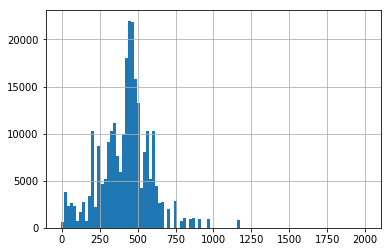

In [536]:
regression2ndMLRound_onTest['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'].hist(bins=100,range=[-5, 2000])

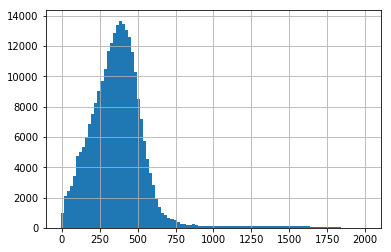

In [537]:
regression2ndMLRound_onTest['DEPT'].hist(bins=100,range=[-5, 2000])

In [538]:
#df[(df>=0)&(df<=20)].dropna()

regression2ndMLRound_onTest_onePerWell = regression2ndMLRound_onTest[regression2ndMLRound_onTest['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']==regression2ndMLRound_onTest['DEPT']].dropna()

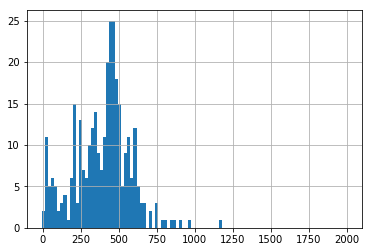

In [539]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'].hist(bins=100,range=[-5, 2000])

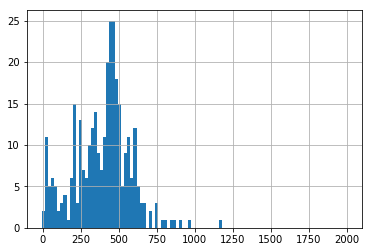

In [540]:
regression2ndMLRound_onTest_onePerWell['DEPT'].hist(bins=100,range=[-5, 2000])

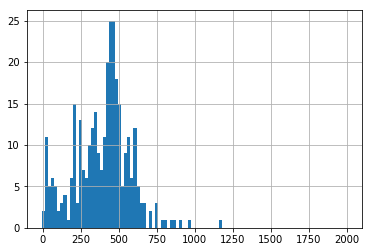

In [541]:
regression2ndMLRound_onTest_onePerWell_noDropZero['DEPT'].hist(bins=100,range=[-5, 2000])

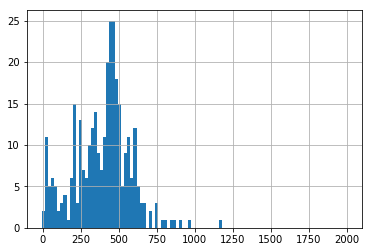

In [542]:
regression2ndMLRound_onTest_onePerWell_noDropZero['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'].hist(bins=100,range=[-5, 2000])

In [543]:
len(regression2ndMLRound_onTest_onePerWell_noDropZero)

321

In [544]:
len(regression2ndMLRound_onTest_onePerWell)

321

In [545]:
len(regression2ndMLRound_onTest['UWI'].unique())

321

In [625]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_DepthPredVsRealTopDepth'] = regression2ndMLRound_onTest_onePerWell_noDropZero['TopTarget_DEPTH'] - regression2ndMLRound_onTest_onePerWell_noDropZero['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']

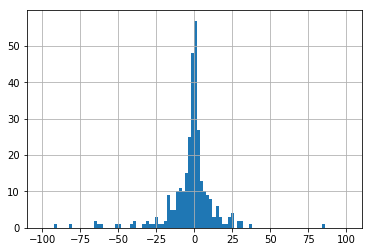

In [628]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_DepthPredVsRealTopDepth'].hist(bins=100,range=[-100, 100])

In [629]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_DepthPredVsRealTopDepth'].mean()

-11.597819314641745

In [632]:
mean_absolute_error_test2ndRoundML_A = mean_absolute_error(regression2ndMLRound_onTest_onePerWell['TopTarget_DEPTH'], regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'])


In [633]:
mean_absolute_error_test2ndRoundML_A

18.854635514018693

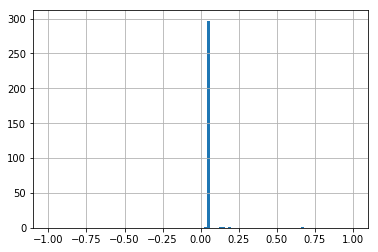

In [634]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'].hist(bins=100,range=[-1, 1])

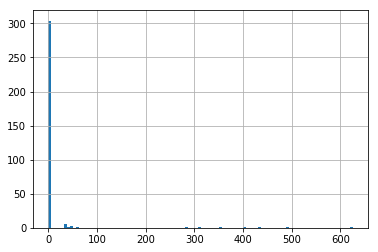

In [557]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'].hist(bins=100)

In [547]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'].mean()

10.331866

In [548]:
mean_absolute_error_test2ndRoundML_wZeros = mean_absolute_error(regression2ndMLRound_onTest_onePerWell['TopTarget_DEPTH'], regression2ndMLRound_onTest_onePerWell['DEPT'])


In [635]:
mean_absolute_error_test2ndRoundML_wZeros

18.854635514018693

Looks like by well prediction evaluation looks worse? not sure why?

In [636]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x']

726         0.042728
1522        0.042728
2361        0.057621
2919        0.057621
3981        0.042728
4769        0.042728
5670        0.042728
6613        0.042728
7243        0.042728
7509        0.057621
8661        0.042728
9501        0.042728
10212       0.057621
11090       0.057621
11688       0.041677
12179       0.042728
12834       0.057621
13787       0.042728
14584       0.057621
15526       0.042728
16287       0.057621
17458       0.042728
18171       0.042728
18800       0.042728
19595       0.042728
20296       0.042728
21054       0.042728
22030       0.042728
22884       0.057621
23976       0.042728
24940       0.042728
25576       0.042728
26407       0.057621
27176       0.181818
28047       0.057621
29021       0.042728
29832       0.057621
30655       0.057621
31438       0.057621
32572       0.042728
33358       0.042728
33700       0.057621
34578       0.057621
35690       0.042728
36004       0.042728
36745       0.042728
37549       0.042728
38329       0

It seems likely the big errors are the only where only the zero class was predicted in the first ML run. These could easily be cut out, if we did this.. we get

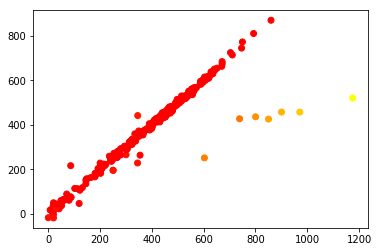

In [637]:
plt.scatter(regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'], regression2ndMLRound_onTest_onePerWell['topTarget_Depth_predBy_NN1thick'],\
            c=regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'], cmap=plt.cm.autumn)

From the plot above, it seems if we plot the predicted top depth based on just the first nearest neighbor vs. the predicted top depth after regression, the ones away from the 1:1 line the furthest are bad predictions that we can ignore and treat as suspect by default. 
    This is great as it means we can identify the worst ones. 

In [638]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'] = pd.to_numeric(regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x']) 

In [639]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred'] = pd.to_numeric(regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']) 

In [640]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_DivXtoDepth'] = regression2ndMLRound_onTest_onePerWell['topTarget_Depth_predBy_NN1thick'] / regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']

In [641]:
regression2ndMLRound_onTest_onePerWell_ThrowOutBad = regression2ndMLRound_onTest_onePerWell[regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_DivXtoDepth'] <= 1.3]

In [642]:
len(regression2ndMLRound_onTest_onePerWell_ThrowOutBad)

314

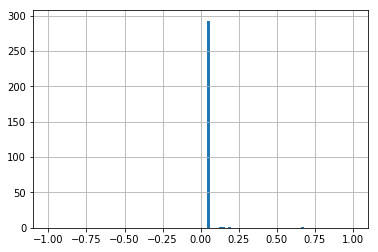

In [643]:
regression2ndMLRound_onTest_onePerWell_ThrowOutBad['TopTarget_Pred_RegressionDistDiffPred_x'].hist(bins=100,range=[-1, 1])

In [645]:
mean_absolute_error_test2ndRoundML_wZeros = mean_absolute_error(regression2ndMLRound_onTest_onePerWell_ThrowOutBad['TopTarget_DEPTH'], regression2ndMLRound_onTest_onePerWell_ThrowOutBad['DEPT'])


In [646]:
mean_absolute_error_test2ndRoundML_wZeros

18.749356687898086

hmm, even when you throw out the obviously baddly predicted points, the results are still worse with regression than you'd get with simple rolling averages of the class prediction and then finding highest ranked row in each well.

probably need to redo this notebook for clarity and got through it again....